With Constant Step Size

Number of Iterations to achieve a Value Function:    85 

Approximately the limit [9.48597636 9.4954782  9.70924067 9.7042801  9.72288656 9.64573793
 9.66081888 9.42251567 9.49618759 9.51083566] 30.31359167797043


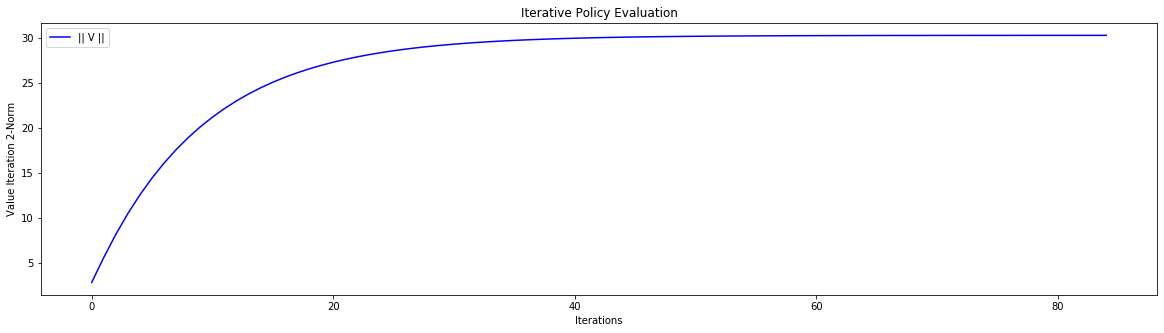

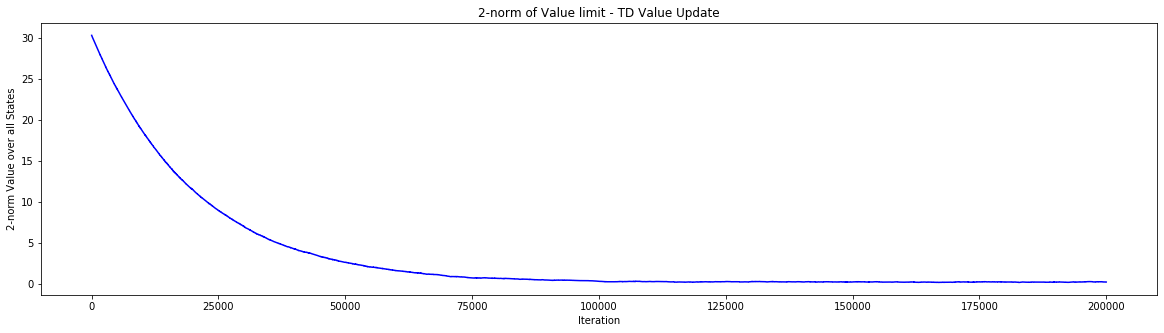

2-norm of Value function after TD Learning:   30.290034598979453 
 Actual value function vector:   [9.58003733 9.3969579  9.80393763 9.56102249 9.74286189 9.60682693
 9.69601825 9.40775135 9.52262826 9.45845829] 

Minimum Delta:   0.1808386602213354



With Diminishing Step Size
Number of Iterations to achieve a Value Function:    93 

Approximately the limit [ 9.83919932  9.91605442  9.89374964 10.08431851  9.95482637  9.6884005
  9.91820901  9.859214    9.85067303  9.94367623  9.88746998  9.94663522
  9.85149357  9.88330522  9.95228411  9.92105385  9.88037065 10.00788176
  9.86031927  9.90045994  9.88323803  9.97430507  9.9301066   9.98604963
  9.93559595 10.03569288  9.71594931  9.93124538  9.93253044  9.88665697
  9.95854863  9.94430018  9.72438509  9.96695382  9.97862972  9.9114877
  9.93587757  9.87246558  9.92018687 10.01531112  9.92306904  9.88473406
  9.8564038   9.93973404  9.90733874  9.8906304   9.88590618  9.96993957
 10.03397808  9.87934159  9.77810128  9.87957058 10.0575

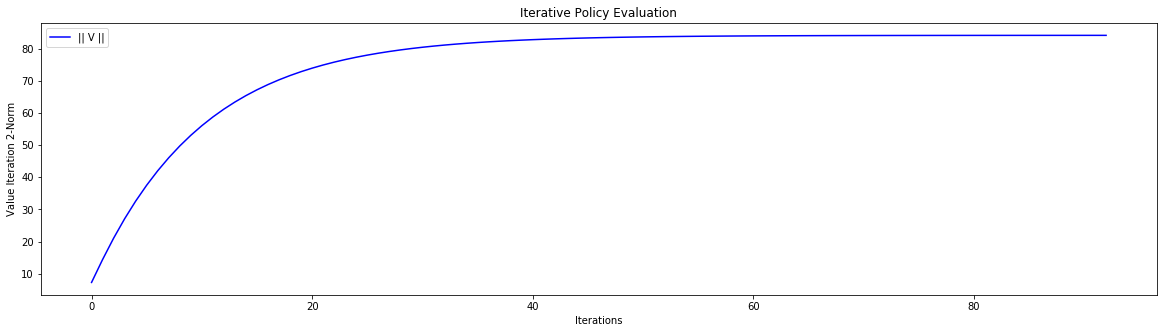

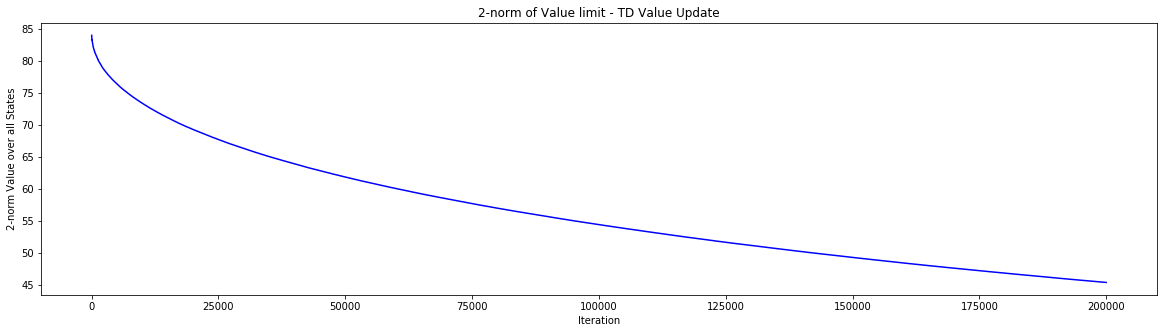

2-norm of Value function after TD Learning:   38.758141473666946 
 Actual value function vector:   [4.46246875 4.50388783 4.50265777 4.75652555 4.62144499 4.38558036
 4.53976389 4.61994575 4.52556806 4.64636956 4.46434958 4.461701
 4.53515868 4.44886142 4.62282967 4.58442297 4.58298817 4.65966801
 4.59146456 4.51503614 4.50053697 4.57306129 4.56622145 4.66271429
 4.5583061  4.68415985 4.47603239 4.59975949 4.59188676 4.56308855
 4.58937763 4.57501485 4.52560335 4.58595299 4.56079127 4.55237013
 4.54450017 4.56401515 4.6914088  4.70448882 4.57463459 4.5235617
 4.44866653 4.57500424 4.54822643 4.62790736 4.71847624 4.68839678
 4.56471194 4.49898254 4.45904352 4.50063267 4.74839761 4.59008089
 4.56828614 4.58020719 4.43927043 4.52009042 4.4467066  4.63120457
 4.64506559 4.60089796 4.56467545 4.5122354  4.57226022 4.53110558
 4.52521675 4.37750363 4.59579303 4.64901231 4.71370714 4.58370781] 

Minimum Delta:   45.38533654964808


In [24]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox.example
import random
import math
from collections import defaultdict


class TDLearner:
    """
    Class that will ues on policy temporal difference
    prediction to solve the model free problem with a given policy

    """

    def __init__(self, policy, states, actions, alpha=0.01, gamma=0.95, beta = 0.5, diminish = None, theta = 0.0001):
        #action value function, mapping each state action pair
        #initialized to have 0 for every new state action pair
        self.value_function = np.zeros(states)

        #discount rate between [0,1]
        self.gamma = gamma

        #step size between [0,1]
        if diminish!=None:
            alpha = 1
        self.alpha = alpha

        #the mapping of states to actions
        self.policy = policy

        self.states = states
        self.actions = actions
        
        np.random.seed(0)
        self.transitionProbabilities, self.rewardMatrix = mdptoolbox.example.rand(states,actions)
        self.rewardMatrix = np.random.rand(actions,states,states)
        #self.rewardMatrix = np.zeros((self.actions,self.states,self.states))

        self.probabilityMatrix = np.zeros((self.states,self.states))
        
        self.diminish = diminish
        self.step_size = self.alpha
        self.beta = beta
        
        #theta value for value iteration must be a small positive number
        self.theta = theta
        
        #the value function that will be used for value iteration to find the value function limit
        self.V = np.zeros(self.states)
        self.optimal_policy = {}
        
        self.exploring= defaultdict(int)
        
    def createProbabilityMatrix(self):
        """
        Create the transition probability matrix based on the Policy pi 
        P(s1,s2) = sum a( P(s1,s2)*pi(a|s) )
        """
        
        for s in range(self.states):
            probabilities = np.zeros(self.states)
            for a in range(self.actions):
                    action_prob = self.policy[a]
                    probabilities += self.transitionProbabilities[a][s]*action_prob
            self.probabilityMatrix[s] = probabilities
            

    def getNextState(self, state):
        
        """
        Using the transition probability matrix we created find the next state the agent is going to
        """    
        next_state = random.choices(population=range(self.states),weights = self.probabilityMatrix[state])
        return next_state[0]


    def getValue(self,state):
        """
        Just return the value of the state action pair given the current estimate of the environment
        :param state: observation that was previously seen
        :param action: action that was take
        :return: the value of that state action pair
        """

        return self.value_function[state]

    def updateValueFunction(self,state, next_state,reward):
        """
        Update the action value function based on the
        :param state: previous state
        :param action: action taken at state
        :param next_state: next state the agent is planning on going ot
        :param next_action: if agent were at next_state the action the agent is planning on taking
        :param reward: the reward it received at state taking action
        :return: void,will change the q_function in the class

        using the on policy temporal difference formula
        V (S) ← V (S) + α[R + γV (S') − V (S)]
        """
        
        self.value_function[state] += self.step_size*(reward + self.gamma*(self.getValue(next_state))-self.getValue(state))


    def getValueVector(self): 
        """
        for the ability to plot the value function getting the values of all the states as a vector
        return: a list of all the values
        """
        
        values = []
        for state, value in self.value_function.items():
            values.append(value)
        return values


    def bellmanUpdate(self,state):
        """
        Carry Out the update for the Value Function
        param: state is the state that the iteration is currently working on
        return: a list of all the values each action calculates
        will be used later to find the policy as well
        """
        
        total = 0
        new_total = 0
        for a in range(self.actions):
            total=0
            for s_prime in range(self.states):
                total+= self.transitionProbabilities[a][state][s_prime]*(self.rewardMatrix[a][state][s_prime]+self.gamma*self.V[s_prime])
            new_total+= self.policy[a]*total
            
        return new_total 
    
    
    def valueIteration(self):
        """
        Perform Value Iteration on the given MDP 
        
        will provide a optimal deterministic policy for this MDP
        will Plot the V(s) function as well 
        """
        
        delta = float("inf")
        iteration = 0
        v_iter = []
        
        deltas = []
        
        #value iteration
        while(delta > self.theta):
            delta = 0
            delta_state = []
            for s in range(self.states):
                v = self.V[s]
                #print("before", self.V[s])
                
                
                #bellman update
                self.V[s] = self.bellmanUpdate(s)
                #print("after", self.V[s])
    
                delta = max(delta, abs(self.V[s]-v))
                delta_state.append(abs(self.V[s]-v))
            norm = np.linalg.norm(self.V)
            v_iter.append(norm)
            #print(norm)
            iteration+=1
            deltas.append(delta_state)
                
                
        #Plotting the Difference between the limit of the Value Function and the value function each iteration
        #The Value function limit seems to be a Value Function with a 2-norm approaching around 16
        print("Number of Iterations to achieve a Value Function:   ", iteration,"\n")
        print("Approximately the limit",self.V, np.linalg.norm(self.V))
        plt.figure(figsize = (20,5))
        plt.plot(range(iteration), v_iter, "b-", label = "|| V ||")
        #plt.plot(range(iteration),np.zeros(iteration)+1.52,"r-", label = "|| V* ||")
        plt.xlabel("Iterations")
        plt.ylabel("Value Iteration 2-Norm")
        plt.title("Iterative Policy Evaluation")
        plt.legend()
        plt.show()
        
        
#         plt.figure(figsize=(20, 10))
#         plt.plot(deltas)
        
    def getOptimalPolicy(self):
        return self.optimal_policy
    
    def takeAction(self,state,action):
        next_state = self.getNextState(state)
        reward = self.rewardMatrix[action][state][next_state]
        
        
        return next_state,reward
    
    
    def runEnvironment(self, iterations):
        """
        Will run the OpenGym AI environment set using on policy Temporal Difference Learning

        :param episodes: the number of episodes you would like to make the enviornment play
        :param maxtimesteps:
        :return: void

        """
        
        """
        Value iteration needs to be run before running this function
        Rough Estimate of the Value Function Limit
        [9.48597636,9.4954782 ,9.70924067,9.7042801, 9.72288656,9.64573793, 9.66081888, 9.42251567, 9.49618759, 9.51083566]
        """
        
        
 
        self.valueIteration()
        
        plt.figure(figsize=(20,5))
        #fig,ax = plt.subplots(2, figsize=(20,10))
        #ax[0].figure(figsize=(20,5))
        #create the transition probability matrix given the policy pi
        self.createProbabilityMatrix()
        
        state = np.random.randint(0,self.states)
        difference = np.zeros(iterations)
        V = np.zeros(iterations)
        total_reward = 0
        actions = np.arange(self.actions)
        for t in range(iterations):
            
#             if t%100==0:
#                 print(t, np.linalg.norm(self.value_function))


            if self.diminish!=None and self.step_size>=0.001 and t>0:
                self.step_size = self.diminish(self.alpha, t, self.beta)


            action = np.random.choice(actions)

            



            
            # take the action into course
            next_state, reward = self.takeAction(state,action)
            
            # update the V function with the new value
            self.updateValueFunction(state,next_state, reward)
            self.exploring[next_state]+=1


            #print(state,next_state,reward,action)

            # move on to the next state and action pair
            state = next_state
            #totalReward += reward
            difference[t] = np.linalg.norm(self.V - self.value_function)
            V[t] = np.linalg.norm(self.value_function)


        plt.plot(range(iterations), difference, 'b-')
        #ax[1].plot(range(iterations), V, 'b-')
            
        plt.title("2-norm of Value limit - TD Value Update")
        #ax[1].set_title("2 norm of Value Function by itself over Timesteps")
        plt.xlabel("Iteration")
        plt.ylabel("2-norm Value over all States")
        plt.show()
        print("2-norm of Value function after TD Learning:  ", np.linalg.norm(self.value_function), "\n Actual value function vector:  ", self.value_function, "\n")
        print("Minimum Delta:  ", min(difference))
    
if __name__ == '__main__':

    np.random.seed(0)
    
    print("With Constant Step Size\n")
    learner = TDLearner(policy={0:0.5,1:0.5},states = 10, actions = 2)
    learner.runEnvironment(200000)
    
    
    print("\n\n\nWith Diminishing Step Size")
    learner = TDLearner(policy={0:0.5,1:0.5},states = 72, actions = 2, diminish = lambda a,k,b: a/(k**b))
    learner.runEnvironment(200000)

